# The complete tool use workflow

## Learning goals

* Understand the entire tool use workflow
* Write properly structured `tool_result` messages
* Implement a chatbot that utilizes tool use

In this lesson, we're going to implement the "full" 4-step tool use workflow we covered earlier.  So far, we've seen that Claude has used tools, but we haven't sent follow up requests to Claude that contain the result of our tool functionality.  Here's a recap of the full 4-step process: 

1. **Provide Claude with tools and a user prompt:** (API request)
    * Define the set of tools you want Claude to have access to, including their names, descriptions, and input schemas.
    * Provide a user prompt that may require the use of one or more of these tools to answer, such as "How many shares of General Motors can I buy with $500?"

2. **Claude uses a tool:** (API response)
    * Claude assesses the user prompt and decides whether any of the available tools would help with the user's query or task. If so, it also decides which tool(s) to use and with what input(s).
    * Claude outputs a properly formatted tool use request.
    * The API response will have a `stop_reason` of `tool_use`, indicating that Claude wants to use an external tool.

3. **Extract tool input(s), run code, and return results:** (API request)
    * On the client side, you should extract the tool name and input from Claude's tool use request.
    * Run the actual tool code on the client side.
    * Return the results to Claude by continuing the conversation with a new user message containing a `tool_result` content block.

4. **Claude uses the tool result to formulate a response:** (API response)
    * After receiving the tool results, Claude will use that information to formulate its final response to the original user prompt.

In this lesson, we'll go through the entire process. 

Here's a diagram with a general overview of the process:

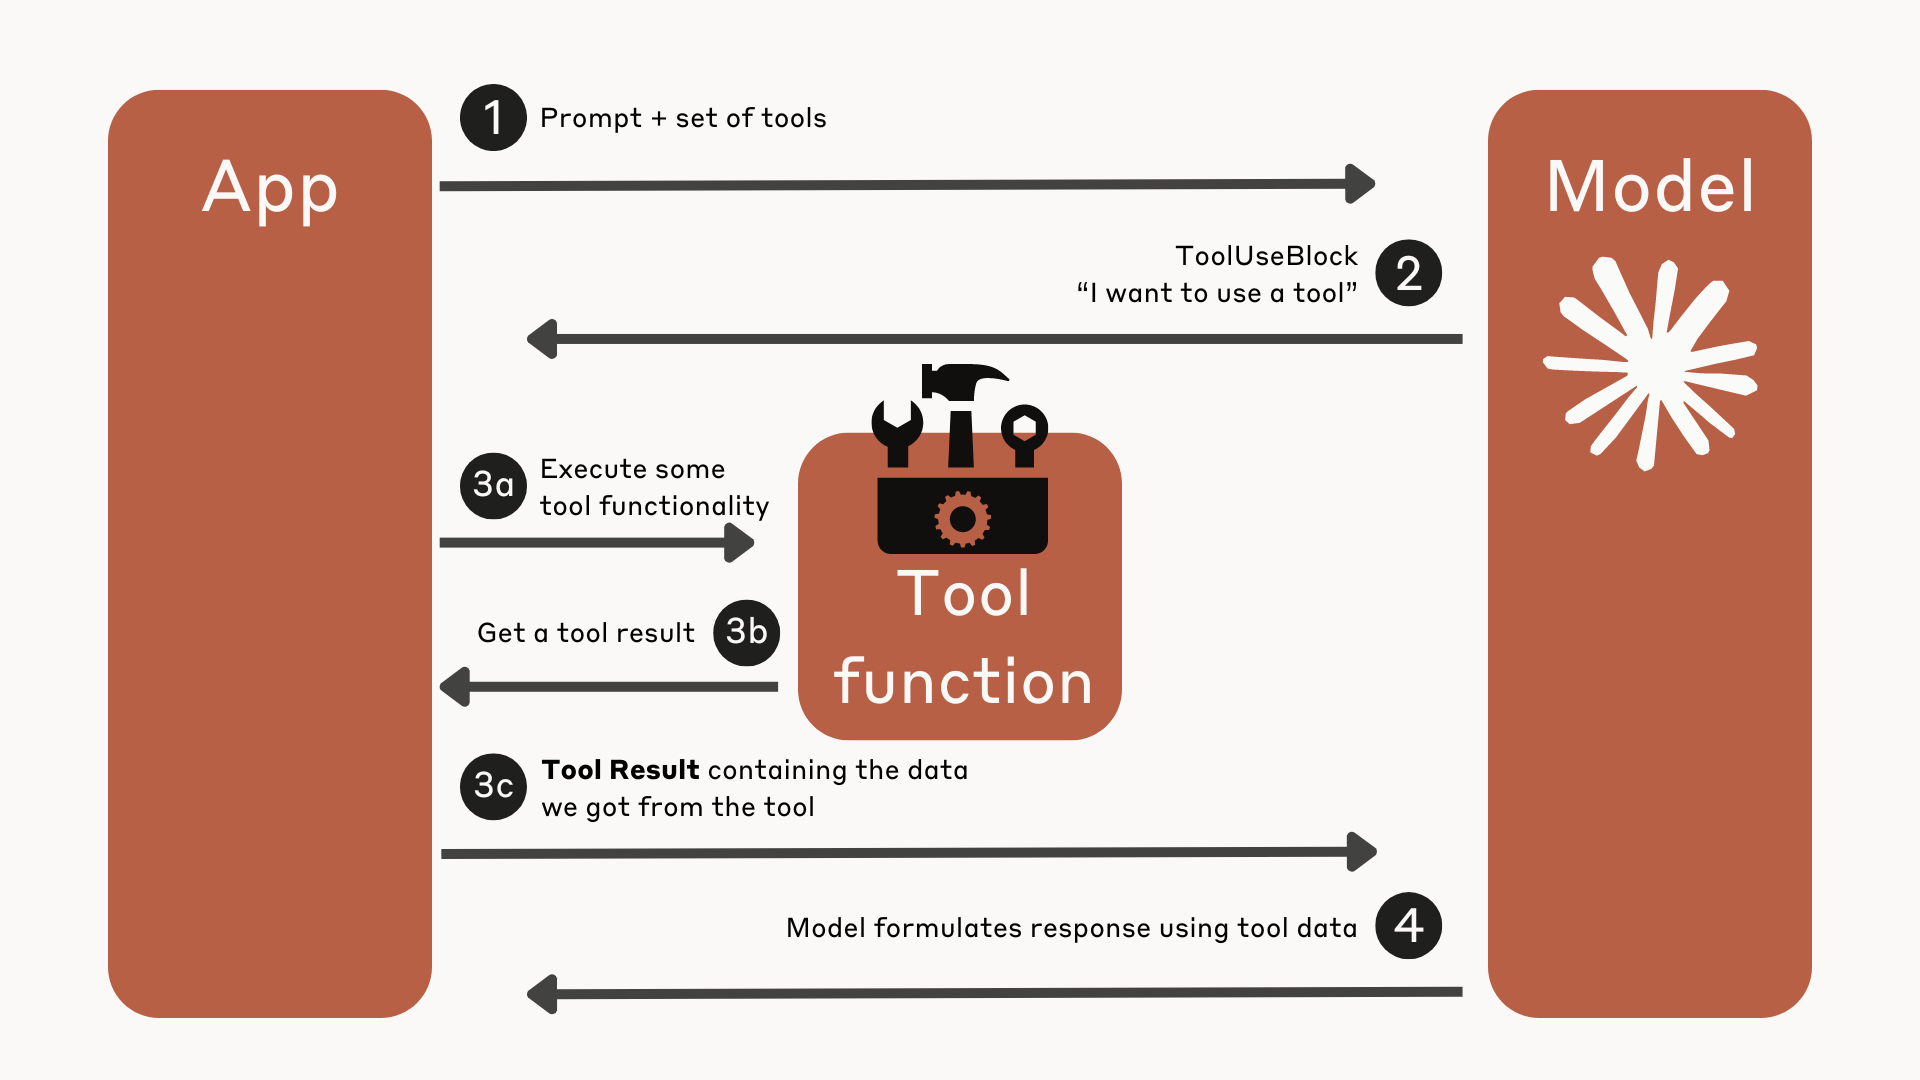

Here's a diagram explaining how our script will work: 

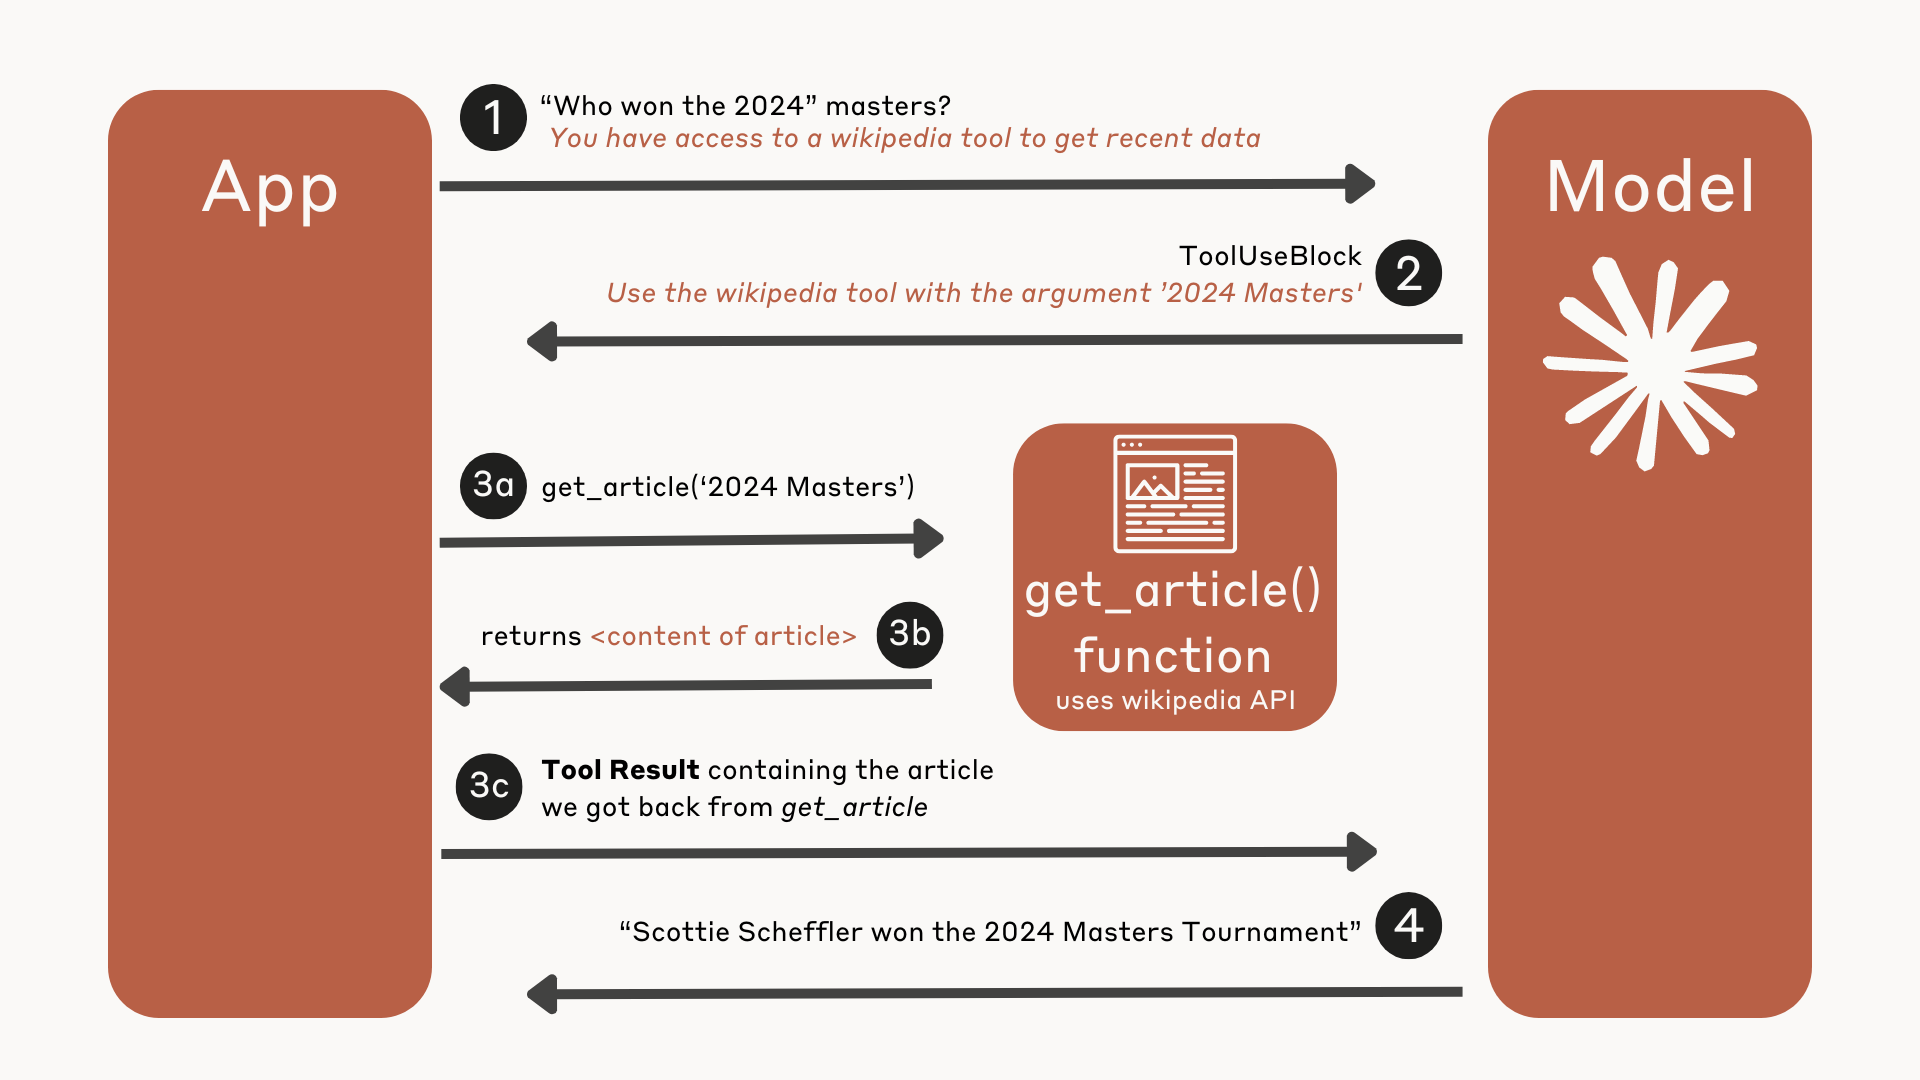


Here are some real exchanges that illustrate the end result we're hoping to achieve: 

> **User**: As of 2024 who has more oscars, Christopher Nolan or Ben Stiller?

> *Claude wants to get an article for Christopher Nolan* (tool use)

> *Claude wants to get an article for Ben Stiller* (tool use)

> **Claude**: As of 2024, filmmaker Christopher Nolan has won 2 Academy Awards for Best Director and Best Picture for his 2023 film Oppenheimer. On the other hand, actor and comedian Ben Stiller has not won any Oscars in his career so far, although he has won other awards like Emmys and MTV Movie Awards. So to directly answer the question, as of 2024, Christopher Nolan has won more Oscars (2) than Ben Stiller, who has not won any.

Here's another example:

> **User:** Who won the 2024 Masters Tournament?

> *Claude wants to get an article for 2024 Masters Tournament*  (tool use)

> **Claude:** Scottie Scheffler won the 2024 Masters Tournament, his second Masters victory. He finished four strokes ahead of runner-up Ludvig Åberg, who was making his debut at the Masters.

If we ask Claude a question that it can answer without needing to use our tool, it should just answer immediately without using our Wikipedia search tool:

> **User:** Who won the 2021 Masters?

> **Claude:** Hideki Matsuyama won the 2021 Masters Tournament, becoming the first Japanese man to win a major golf championship. He finished with a score of 278 (-10) to claim the green jacket at Augusta National Golf Club.



Here's a look at what the `messages` list looks like by the end of this process:

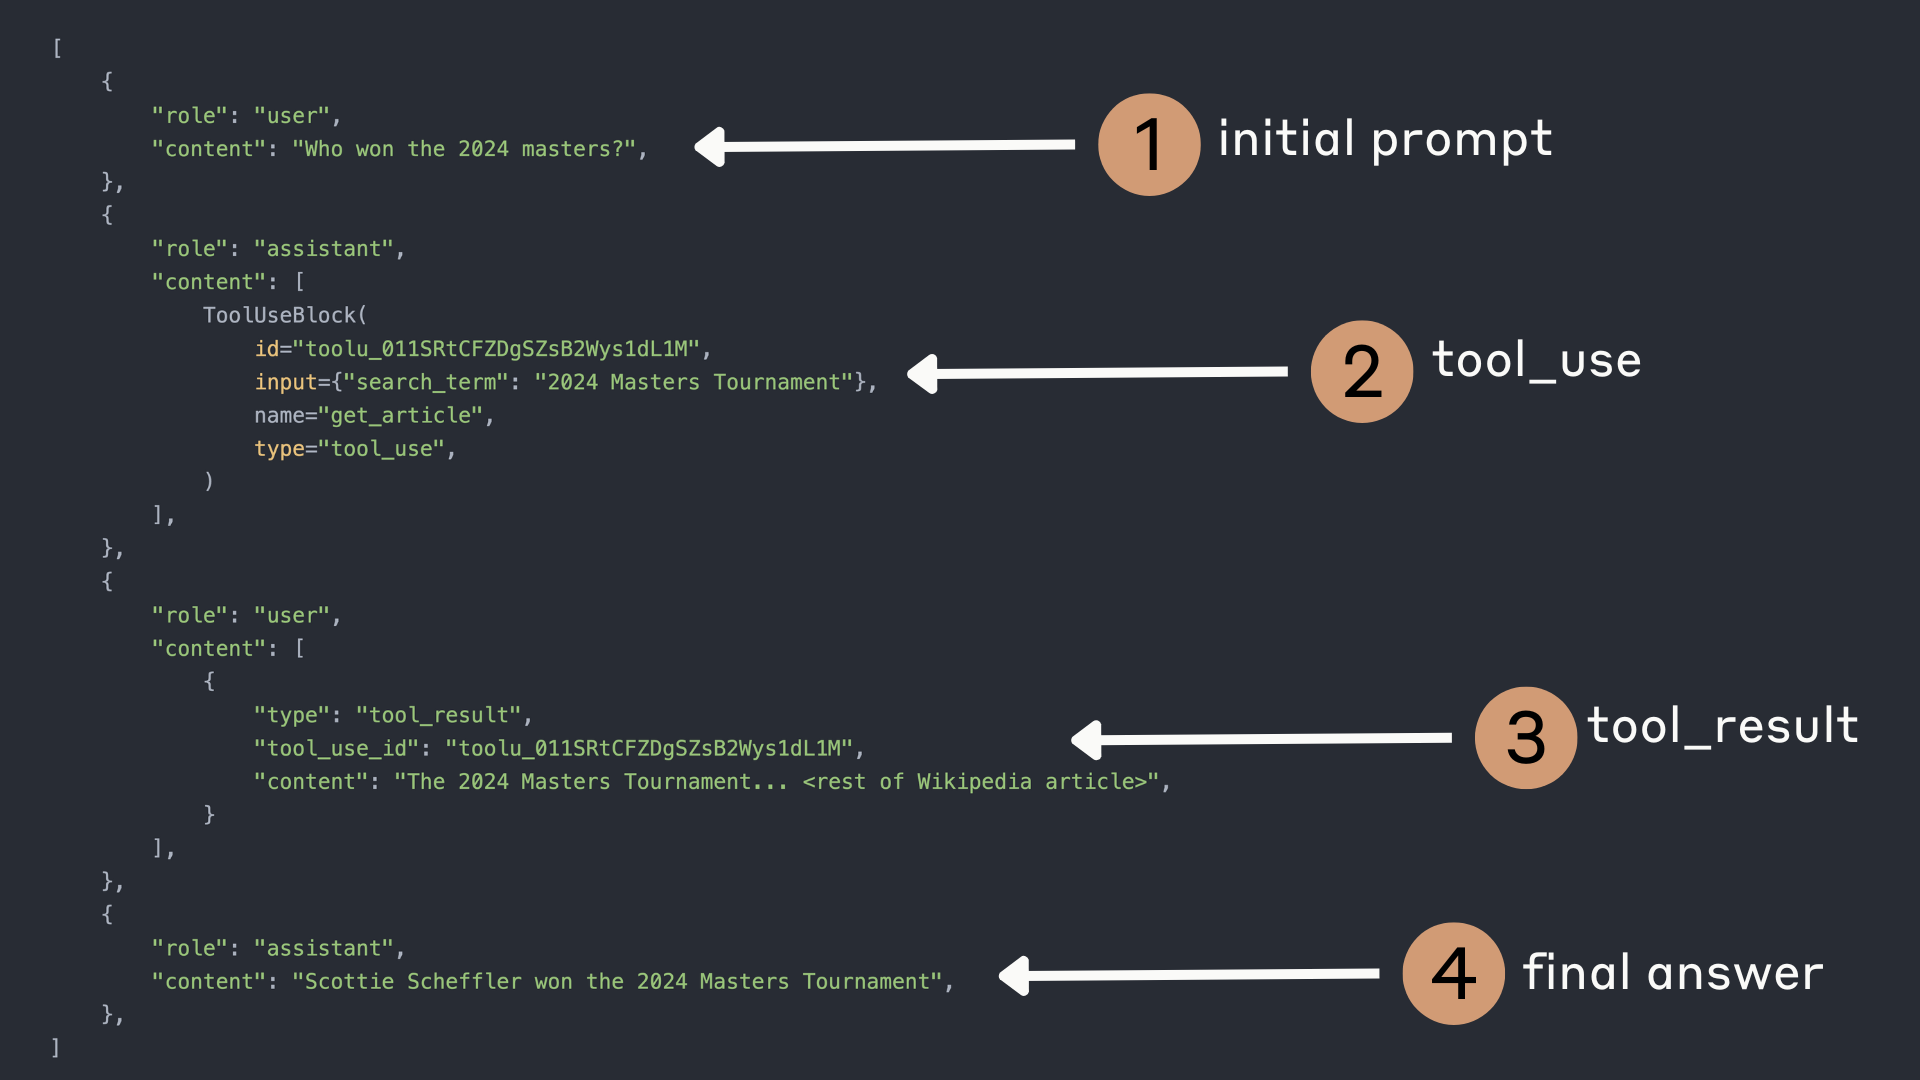

The main new topic in this lesson is how to properly format our `tool_result` user message when responding to Claude's `tool_use` message.

## Building the complete workflow

### 1. Defining our Wikipedia search function

Before we do anything with Claude, let's write a simple function to search Wikipedia.  The following function uses the `wikipedia` package to search for matching wikipedia pages based on a search term.  To keep things simple, we take the first returned page title and then use that to access the corresponding page content.

Note: this simple function assumes we find a Wikipedia article. To keep things brief, the function has no error handling which is not a great idea in the real world!

In [1]:
import wikipedia

def get_article(search_term):
    results = wikipedia.search(search_term)
    first_result = results[0]
    page = wikipedia.page(first_result, auto_suggest=False)
    return page.content

In [15]:
article = get_article("Superman")
print(article[:500]) # article is very long, so let's just print a preview

Superman is a superhero who appears in American comic books published by DC Comics. The character was created by writer Jerry Siegel and artist Joe Shuster, and debuted in the comic book Action Comics #1 (cover-dated June 1938 and published April 18, 1938). Superman has been adapted to a number of other media, which includes radio serials, novels, films, television shows, theater, and video games.
Superman was born on the fictional planet Krypton with the birth name of Kal-El. As a baby, his par


In [16]:
article = get_article("Zendaya")
print(article[:500]) # article is very long, so let's just print a preview

Zendaya Maree Stoermer Coleman (  zən-DAY-ə; born September 1, 1996) is an American actress and singer. She has received various accolades, including two Primetime Emmy Awards and a Golden Globe Award. Time magazine named her one of the 100 most influential people in the world in 2022.
Born and raised in Oakland, California, Zendaya began her career as a child model and backup dancer. She made her television debut as Rocky Blue in the Disney Channel sitcom Shake It Up (2010–2013) and starred as 


### 2. Writing the tool definition
Next up, we need to define our tool using the proper JSON Schema format.  This is a very simple tool definition because the function expects a single argument: the search term string.  

In [2]:
article_search_tool = {
    "name": "get_article",
    "description": "A tool to retrieve an up to date Wikipedia article.",
    "input_schema": {
        "type": "object",
        "properties": {
            "search_term": {
                "type": "string",
                "description": "The search term to find a wikipedia article by title"
            },
        },
        "required": ["search_term"]
    }
}

### 3. Provide Claude with the tool and user prompt

Next, we'll tell Claude it has access to the Wikipedia search tool and ask it to answer a question we know it cannot answer without the tool, like "Who won the 2024 Masters Tournament?"

In [3]:
from anthropic import Anthropic
from dotenv import load_dotenv

load_dotenv()

client = Anthropic()

messages = [{"role": "user", "content": "who won the 2024 Masters Tournament?"}]

response = client.messages.create(
        model="claude-3-sonnet-20240229",
        messages=messages,
        max_tokens=1000,
        tools=[article_search_tool]
    )

### 4. Claude uses the tool (API response)

Let's look at the response we got back.  Claude wants to use our tool!

In [4]:
response.content

[TextBlock(text='Okay, let me see if I can find information about the winner of the 2024 Masters Tournament on Wikipedia:', type='text'),
 ToolUseBlock(id='toolu_01CWuduGjgSRfsYJUNC2wxi7', input={'search_term': '2024 Masters Tournament'}, name='get_article', type='tool_use')]

Claude's response contains 2 blocks: 

* A TextBlock with the text "Okay, let me use the available tool to try and find information on who won the 2024 Masters Tournament on Wikipedia:"

```
TextBlock(text='Okay, let me use the available tool to try and find information on who won the 2024 Masters Tournament:', type='text')
```

* A ToolUseBlock calling our `get_article` tool with the `search_term` "2024 Masters Tournament"

```
ToolUseBlock(id='toolu_01MbstBxD654o9hE2RGNdtSr', input={'search_term': '2024 Masters Tournament'}, name='get_article', type='tool_use')]
```


### 5. Extract tool input(s), run code, and return results (API request)

Now that Claude has responded telling us it wants to use a tool, it's time for us to actually run the underlying functionality AND respond back to Claude with the corresponding Wikipedia page content.

**We need to pay special attention to make sure we update our `messages` list**

We'll begin by updating our `messages` list to include Claude's most recent response:

In [5]:
messages.append({"role": "assistant", "content": response.content})

In [6]:
messages

[{'role': 'user', 'content': 'who won the 2024 Masters Tournament?'},
 {'role': 'assistant',
  'content': [TextBlock(text='Okay, let me see if I can find information about the winner of the 2024 Masters Tournament on Wikipedia:', type='text'),
   ToolUseBlock(id='toolu_01CWuduGjgSRfsYJUNC2wxi7', input={'search_term': '2024 Masters Tournament'}, name='get_article', type='tool_use')]}]

Next, we'll extract the specific tool and arguments that Claude wants to use:

In [7]:
# This is a simple, but brittle way of getting the tool use information
# We're simply taking the last block from Claude's response.
tool_use = response.content[-1]
tool_name = tool_use.name
tool_input = tool_use.input
print("Tool name: ", tool_name)
print("Tool input", tool_input)

Tool name:  get_article
Tool input {'search_term': '2024 Masters Tournament'}


Next, we'll make sure Claude is calling the `get_article` tool we're expecting.  We'll take the `search_term` Claude came up with and pass that to the `get_article` function we wrote earlier.

In [17]:
if tool_name == "get_article":
    search_term = tool_input["search_term"]
    wiki_result = get_article(search_term)
    print(f"Searching Wikipedia for {search_term}")
    print("WIKIPEDIA PAGE CONTENT:")
    print(wiki_result[:500]) #just printing a small bit of the article because it's so long

Searching Wikipedia for 2024 Masters Tournament
WIKIPEDIA PAGE CONTENT:
The 2024 Masters Tournament was the 88th edition of the Masters Tournament and the first of the men's four major golf championships held in 2024. The tournament was played from April 11–14 at Augusta National Golf Club in Augusta, Georgia, United States. Scottie Scheffler won his second Masters and major, four strokes ahead of runner-up Ludvig Åberg, who was playing in his first major. Scheffler became the fourth-youngest two-time winner of the tournament and the second player, after Tiger Woods


Now that we've executed the function Claude wanted us to call, it's time to respond back to Claude with the Wikipedia page data.

As we know, when Claude wants to use a tool, it responds to us with a `stop_reason` of `tool_use` and one or more `tool_use` content blocks in the API response that include:
* `id`: A unique identifier for this particular tool use block. This will be used to match up the tool results later.
* `name`: The name of the tool being used.
* `input`: An object containing the input being passed to the tool, conforming to the tool's `input_schema`.

Once we have executed our underlying tool function, we need to respond back to Claude with a particular format as well. Specifically, to continue the conversation, we need to send a new message with the **role of `user`** and a content block **containing the `tool_result` type**, along with the following information:
* `tool_use_id`: The id of the tool use request this is a result for.
* `content`: The result of the tool, as a string (e.g. "content": "15 degrees") or list of nested content blocks (e.g. "content": [{"type": "text", "text": "15 degrees"}]\). 
* `is_error` (optional): Set to true if the tool execution resulted in an error.

Here's an example of what a properly formatted `tool_result` message looks like: 

In [ ]:
{
  "role": "user",
  "content": [
    {
      "type": "tool_result",
      "tool_use_id": "toolu_01A09q90qw90lq917835lq9",
      "content": "The result of actually calling the tool goes here"
    }
  ]
}

Let's do this now for our Wikipedia search example. We need to form a properly constructed tool response message to send our Wikipedia search result back to Claude:

In [9]:
tool_response = {
    "role": "user",
    "content": [
        {
        "type": "tool_result",
        "tool_use_id": tool_use.id,
        "content": wiki_result
        }
    ]
}

In [10]:
# Notice the long wikipedia article content!
tool_response

{'role': 'user',
 'content': [{'type': 'tool_result',
   'tool_use_id': 'toolu_01CWuduGjgSRfsYJUNC2wxi7',
   'content': "The 2024 Masters Tournament was the 88th edition of the Masters Tournament and the first of the men's four major golf championships held in 2024. The tournament was played from April 11–14 at Augusta National Golf Club in Augusta, Georgia, United States. Scottie Scheffler won his second Masters and major, four strokes ahead of runner-up Ludvig Åberg, who was playing in his first major. Scheffler became the fourth-youngest two-time winner of the tournament and the second player, after Tiger Woods in 2001, to win both the Masters and The Players Championship in the same calendar year. \n\n\n== Course ==\n\nThe only change to the course for the 2024 tournament was the lengthening of the second hole by ten yards.\n\n\n== Field ==\nParticipation in the Masters Tournament is by invitation only, and the tournament has the smallest field of the major championships. There are

Next, we need to add our `tool_response` message to our messages list: 

In [11]:
messages.append(tool_response)

Our `messages` list now looks like this: 

* User: Who won the 2024 Masters Tournament?
* Assistant: I want to use the `get_article` tool with `search_term` "2024 Masters Tournament"
* User: Here's the tool result that contains the Wikipedia article you asked for

Here's a diagram that illustrates this.

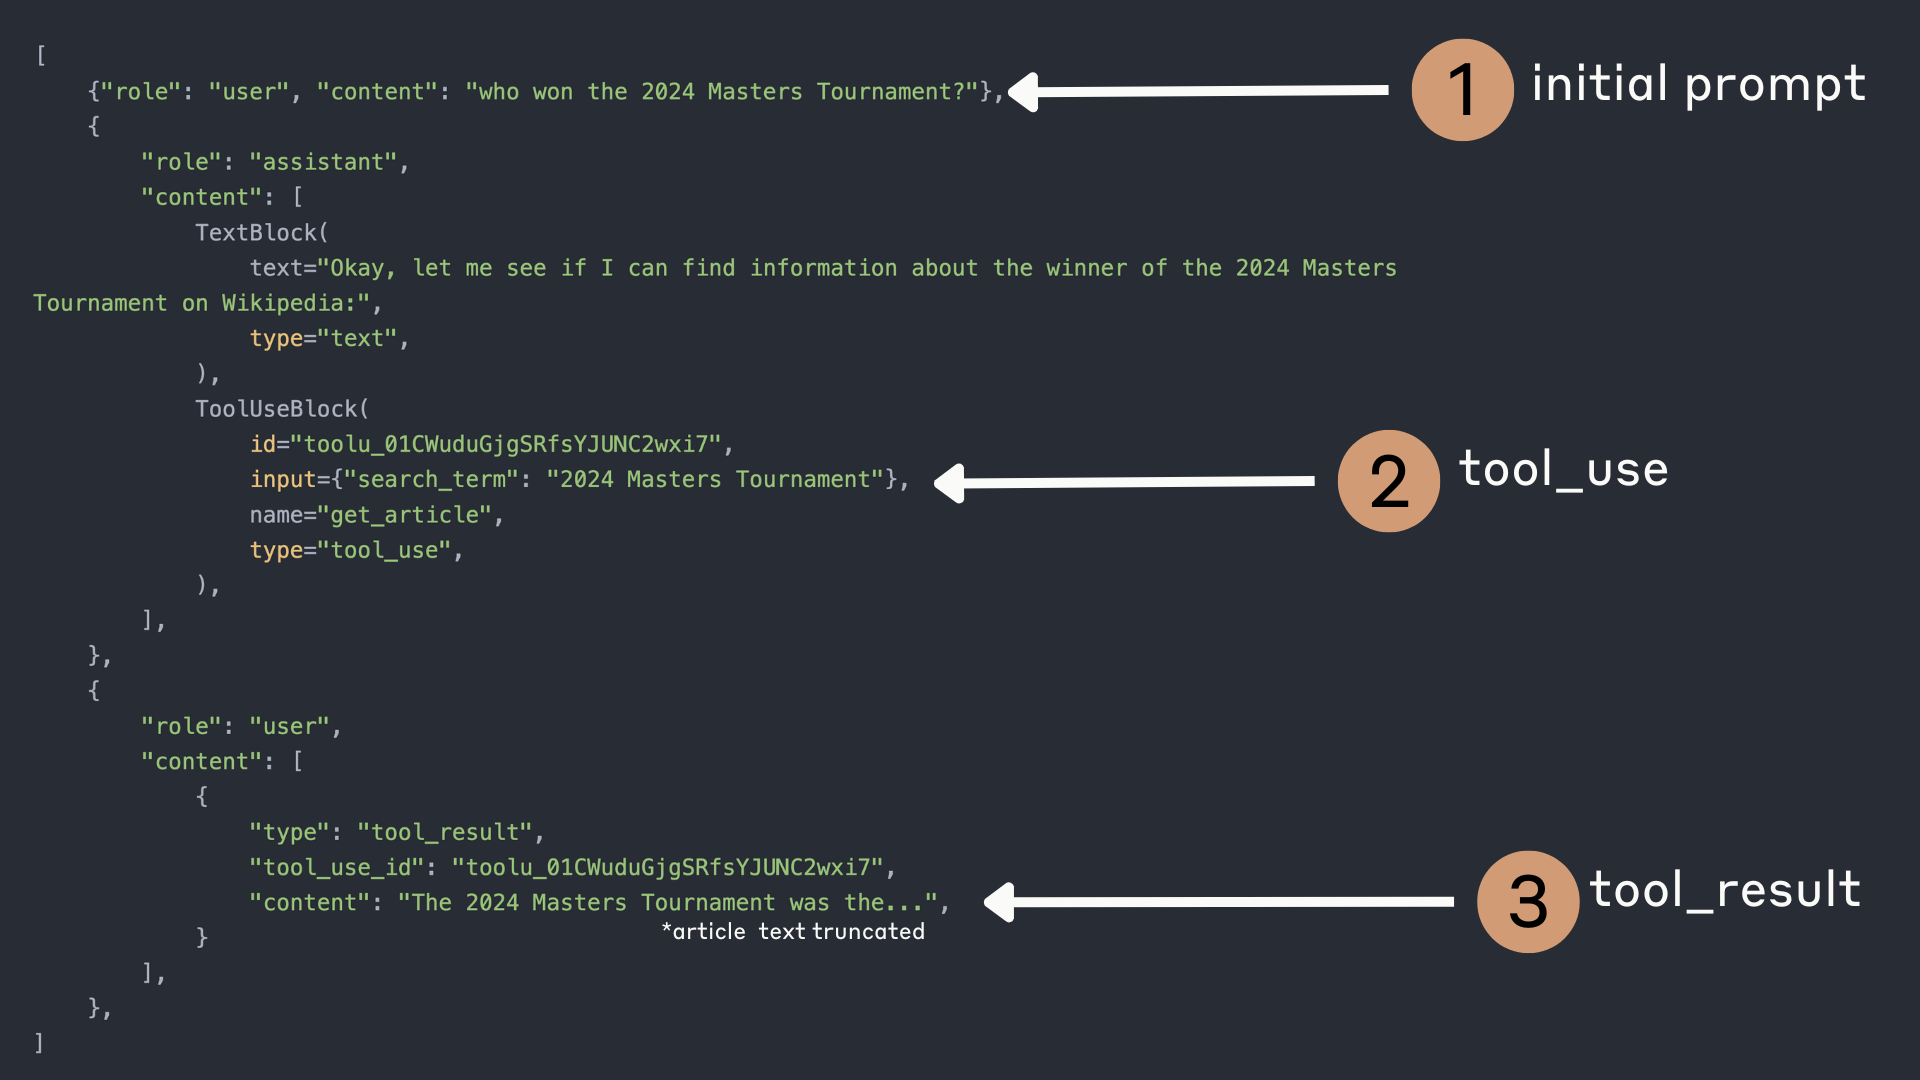

Note that the initial `id` matches the `tool_use_id` in our follow up user message


### 6. Claude uses the tool result to formulate a response: (API response)

Finally, we can use our updated `messages` list and send a new request to Claude:

In [13]:
follow_up_response = client.messages.create(
    model="claude-3-sonnet-20240229",
    messages=messages,
    max_tokens=1000,
    tools=[article_search_tool]
)

In [14]:
follow_up_response.content[0].text

"Based on the summary from Wikipedia, it appears that Scottie Scheffler won the 2024 Masters Tournament. He shot a final round 68 to finish at 11-under par, four shots ahead of runner-up Ludvig Åberg. This was Scheffler's second Masters title, having also won in 2022. So the key details are:\n\n2024 Masters Tournament Winner: Scottie Scheffler (-11)\nRunner-Up: Ludvig Åberg (-7)\n\nThe Wikipedia article provides a detailed recap of each round and how Scheffler was able to separate himself from the rest of the field over the final 18 holes to claim his second green jacket. Let me know if you need any other information from the summary!"

Claude now has the information needed to answer the initial question and responds back with:

> 'Based on the Wikipedia article summary, it appears that Scottie Scheffler won the 2024 Masters Tournament. He shot a final round...'

We have now completed all 4 steps of the process! 

***

## Improving the code

At a bare minimum, we probably want to put all the above code into a reusable function so we can try it out a few times:

In [83]:

def answer_question(question):
    messages = [{"role": "user", "content": question}]

    response = client.messages.create(
        model="claude-3-sonnet-20240229",
        messages=messages,
        max_tokens=1000,
        tools=[article_search_tool]
    )
    
    if(response.stop_reason == "tool_use"):
        tool_use = response.content[-1]
        tool_name = tool_use.name
        tool_input = tool_use.input
        #Add Claude's tool use call to messages:
        messages.append({"role": "assistant", "content": response.content})

        if tool_name == "get_article":
            search_term = tool_input["search_term"]
            print(f"Claude wants to get an article for {search_term}")
            wiki_result = get_article(search_term) #get wikipedia article content
            #construct our tool_result message
            tool_response = {
                "role": "user",
                "content": [
                    {
                    "type": "tool_result",
                    "tool_use_id": tool_use.id,
                    "content": wiki_result
                    }
                ]
                }
            messages.append(tool_response)
            #respond back to Claude
            response = client.messages.create(
                model="claude-3-sonnet-20240229",
                messages=messages,
                max_tokens=1000,
                tools=[article_search_tool]
            )
            print("Claude's final answer:")
            print(response.content[0].text)

    else:
        print("Claude did not call our tool")
        print(response.content[0].text)

In [87]:
answer_question("Who won the 2024 F1 Australian Grand Prix")

Claude want to get an article for 2024 F1 Australian Grand Prix
Claude's Final Answer:

The key information from the Wikipedia article is:

Carlos Sainz Jr. of Ferrari won the 2024 Australian Grand Prix, with his teammate Charles Leclerc finishing second. Lando Norris of McLaren finished third. 

Max Verstappen of Red Bull Racing started on pole but retired early due to a brake failure, ending his streak of 9 consecutive wins.

The race set a new attendance record at Albert Park of 452,055 spectators over the weekend, making it the most attended sporting event ever in Melbourne.


In [90]:
answer_question("Who stars in the movie Challengers?")

Claude want to get an article for Challengers (2023 film)
Claude's Final Answer:
Based on the plot summary and cast details from Wikipedia, the main stars of the 2023 film Challengers are:

- Zendaya as Tashi Duncan
- Josh O'Connor as Patrick Zweig  
- Mike Faist as Art Donaldson

The film also features supporting roles by Darnell Appling, AJ Lister, Nada Despotovich, Naheem Garcia, and Hailey Gates.

So the three leads starring in the romantic sports drama Challengers are Zendaya, Josh O'Connor, and Mike Faist.


In [91]:
#Let's try an example that Claude should NOT need our tool to answer:
answer_question("Who wrote the book 'Life of Pi'")

Claude want to get an article for Life of Pi
Claude's Final Answer:
Based on the Wikipedia article retrieved, the book 'Life of Pi' was written by the Canadian author Yann Martel and published in 2001. It won the Man Booker Prize in 2002 and has sold over 10 million copies worldwide. The novel tells the story of an Indian boy named Pi Patel who survives for 227 days stranded on a lifeboat in the Pacific Ocean after a shipwreck, with a Bengal tiger named Richard Parker as his only companion.


Notice that Claude called our Wikipedia tool to help answer this last question, even though Claude already knows the answer.  "Life of Pi" was published in 2001, long before Claude's training cutoff!

***

## Improving our prompt

As we saw in a previous lesson, sometimes Claude is overly eager to use tools.  An easy wasy to fix this is through the system prompt.


We could add a system prompt that looks something like this:

In [18]:
system_prompt = """
    You will be asked a question by the user. 
    If answering the question requires data you were not trained on, you can use the get_article tool to get the contents of a recent wikipedia article about the topic. 
    If you can answer the question without needing to get more information, please do so. 
    Only call the tool when needed. 
    """

Let's update our function to use this new system prompt:

In [93]:
def answer_question(question):
    system_prompt = """
    You will be asked a question by the user. 
    If answering the question requires data you were not trained on, you can use the get_article tool to get the contents of a recent wikipedia article about the topic. 
    If you can answer the question without needing to get more information, please do so. 
    Only call the tool when needed. 
    """

    messages = [{"role": "user", "content": question}]

    response = client.messages.create(
        model="claude-3-sonnet-20240229",
        system=system_prompt, 
        messages=messages,
        max_tokens=1000,
        tools=[article_search_tool]
    )
    
    if(response.stop_reason == "tool_use"):
        tool_use = response.content[-1]
        tool_name = tool_use.name
        tool_input = tool_use.input
        #Add Claude's tool use call to messages:
        messages.append({"role": "assistant", "content": response.content})

        if tool_name == "get_article":
            search_term = tool_input["search_term"]
            print(f"Claude wants to get an article for {search_term}")
            wiki_result = get_article(search_term) #get wikipedia article content
            #construct our tool_result message
            tool_response = {
                "role": "user",
                "content": [
                    {
                    "type": "tool_result",
                    "tool_use_id": tool_use.id,
                    "content": wiki_result
                    }
                ]
                }
            messages.append(tool_response)
            #respond back to Claude
            response = client.messages.create(
                model="claude-3-sonnet-20240229",
                system=system_prompt, 
                messages=messages,
                max_tokens=1000,
                tools=[article_search_tool]
            )
            print("Claude's final answer:")
            print(response.content[0].text)

    else:
        print("Claude did not call our tool")
        print(response.content[0].text)

Let's try asking the same question:

In [94]:
answer_question("Who wrote the book 'Life of Pi'")

Claude did not call our tool
The book 'Life of Pi' was written by the Canadian author Yann Martel. It was published in 2001 and went on to become an international bestseller. The novel blends elements of magical realism, adventure fiction and philosophical fiction. It tells the story of an Indian boy named Pi who survives for 227 days adrift in the Pacific Ocean after a shipwreck, in the company of a Bengal tiger named Richard Parker. The book won the Man Booker Prize in 2002 and was later adapted into an acclaimed film directed by Ang Lee in 2012.


It worked! Claude did not use our tool when it wasn't needed.  Let's make sure it still works when answering questions that do require recent knowledge:

In [96]:
answer_question("Who wrote the score for the movie Challengers?")

Claude want to get an article for Challengers (film)
Claude's Final Answer:
Based on the Wikipedia article summary, the score for the film Challengers was composed by Trent Reznor and Atticus Ross. The relevant quote is:

"Trent Reznor and Atticus Ross composed the film's score, having previously worked with Guadagnino on 2022's Bones and All. Post-production was completed by April 2023."

So to answer your original question - the musical score for the 2024 film Challengers was written by the composer duo Trent Reznor and Atticus Ross.


It's working as intended in both situations! Now let's work on getting Claude's response to be a little more succinct.  It's great that Claude is explaining HOW it came up with the correct answer, but it's a little verbose. Let's do a little basic prompt engineering to fix that.  

Let's try this:

In [102]:
prompt = f"""
    Answer the following question <question>Who wrote the movie Poor Things?</question>
    When you can answer the question, keep your answer as short as possible and enclose it in <answer> tags
    """

Here's our function updated with the new prompt:

In [103]:
def answer_question(question):
    system_prompt = """
    You will be asked a question by the user. 
    If answering the question requires data you were not trained on, you can use the get_article tool to get the contents of a recent wikipedia article about the topic. 
    If you can answer the question without needing to get more information, please do so. 
    Only call the tool when needed. 
    """
    prompt = f"""
    Answer the following question <question>{question}</question>
    When you can answer the question, keep your answer as short as possible and enclose it in <answer> tags
    """
    messages = [{"role": "user", "content": prompt}]

    response = client.messages.create(
        model="claude-3-sonnet-20240229",
        system=system_prompt, 
        messages=messages,
        max_tokens=1000,
        tools=[article_search_tool]
    )
    
    if(response.stop_reason == "tool_use"):
        tool_use = response.content[-1]
        tool_name = tool_use.name
        tool_input = tool_use.input
        #Add Claude's tool use call to messages:
        messages.append({"role": "assistant", "content": response.content})

        if tool_name == "get_article":
            search_term = tool_input["search_term"]
            print(f"Claude wants to get an article for {search_term}")
            wiki_result = get_article(search_term) #get wikipedia article content
            #construct our tool_result message
            tool_response = {
                "role": "user",
                "content": [
                    {
                    "type": "tool_result",
                    "tool_use_id": tool_use.id,
                    "content": wiki_result
                    }
                ]
                }
            messages.append(tool_response)
            #respond back to Claude
            response = client.messages.create(
                model="claude-3-sonnet-20240229",
                system=system_prompt, 
                messages=messages,
                max_tokens=1000,
                tools=[article_search_tool]
            )
            print("Claude's final answer:")
            print(response.content[0].text)

    else:
        print("Claude did not call our tool")
        print(response.content[0].text)

In [100]:
answer_question("Who wrote the score for the movie Challengers?")

Claude want to get an article for Challengers (2023 film)
Claude's Final Answer:
<answer>The score for the movie Challengers was composed by Trent Reznor and Atticus Ross.</answer>


In [101]:
answer_question("How many legs does an octopus have?")

Claude did not call our tool
<answer>An octopus has 8 legs.</answer>


Much better! Claude is now responding with answers without a bunch of additional "thinking" and explanation about how it arrived at the answer.

***

## Exercise

Can you update this code so that it fulfills the following requirements:
* Claude might not get enough information from the first Wikipedia page we respond with.  We haven't handled that situation yet.  Imagine we ask Claude "How many Oscars does Christopher Nolan have?  Does he have more than the number of Emmy's that Ben Stiller has?"  Claude would need to search Christopher Nolan's Wikipedia page AND Ben Stiller's page, likely one after another.  Our code currently does not allow this, so let's build in that functionality! **Hint: use a loop!**  
* Extract the answer from the `<answer></answer>` tags Claude currently responds with so that you only print out the actual answer content.
* Can you turn this into a full command-line chatbot that continuously asks a user to enter a query and then responds with the answer over and over until a user quits the program? The output could look something like this: 



Here's a screenshot of an example conversation session: 

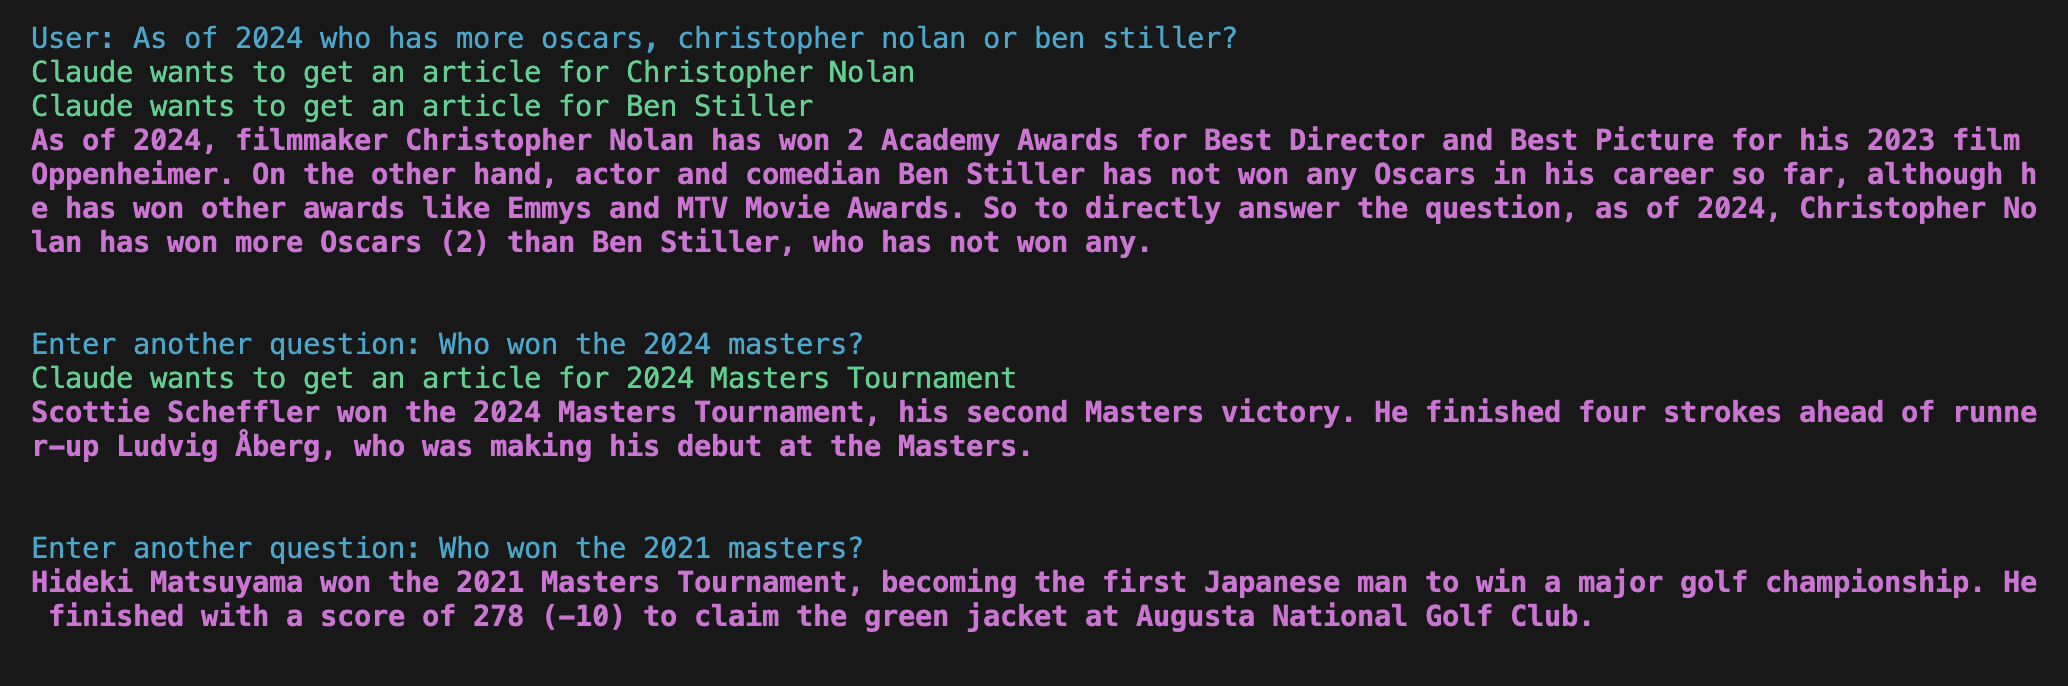